# Tarea 3 Métodos No Lineales
---
## Integrantes: 
- *José Eduardo Caimapo* -  jose.caimapo.12@sansano.usm.cl - 201373573-8
- *Rodrigo Sepúlveda* - rodrigo.sepulveda.12@sansano.usm.cl - 201204766-8

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
from   sklearn.utils           import check_random_state
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import precision_recall_fscore_support,classification_report,mean_absolute_error
from   sklearn.tree            import DecisionTreeClassifier as Tree
from   sklearn.decomposition   import PCA, KernelPCA
from   sklearn.model_selection import GridSearchCV
from   sklearn.svm             import SVC
from   keras.models      import Sequential
from   keras.layers      import Dense
from   keras.optimizers  import SGD
import itertools

Using TensorFlow backend.


In [16]:
from sklearn.svm import SVC
def score_the_model(model,x,y,xt,yt,name,targets):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt,yt)
    print("sklearn decision tree, training error: %f" %mean_absolute_error(y, model.predict(x)))
    print("sklearn decision tree, testing error: %f" %mean_absolute_error(yt, model.predict(xt)))
    print ("%s Training Accuracy: %f"%(name,acc_tr))
    print ("%s Test Accuracy: %f"%(name,acc_test))
    print ("Detailed Analysis Testing Results ...")
    print (classification_report(yt, model.predict(xt),target_names=targets))

## 1. Small Circle inside Large Circle

El objetivo de esta sección es experimentar con algunos modelos no-lineales sobre un problema de juguete generado  para visualizar  algoritmos  de clustering.  Se  trata  de  un  problema  de  clasificación  a  todas  luces linealmente inseparable, en el sentido que, si denotamos por $x \in I\!R^{2}$ un patrón de entrada y por $y \in \{1, -1\}$ su correspondiente etiqueta, no existen $w \in I\!R^2,b \in I\!R$ tal que $y(w^T x + b) \geq p \gt 0$
El problema nos permite 
hacer un recorrido rápido por las grandes ideas en la búsqueda de la ***no-linealidad***.



#### a) Escriba una función que genere n datos etiquetados de la forma $\{(x_1,y_1),...,(x_n,y_n)\}$ con $x_i \in I\!R^{2}, y_i \in \{ 0 , 1\}$, con una distribución de probabilidad que refleje la configuración linealmente inseparable que muestra la Fig 1. Utilice esta función para crear 1000 datos de entrenamiento y 1000 datos de pruebas. Para medir la tendencia de los modelos a ***sobre ajuste***, agregue un $5 \%$ de ruido al dataset, generando x's cercanos a la frontera. Genere un gráfico que muestre datos de entrenamiento y pruebas, identificando cada clase con un color diferente.

In [3]:
def do_circles(n=2000,noisy_n=0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp),np.ones(n // 2, dtype=np.intp)])
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5, random_state=42)
    return X_train,y_train,X_test,y_test

In [4]:
def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(12, 8))
    axis.scatter(X_train[:,0],X_train[:,1],s=30,c=Y_train,zorder=10,cmap='cool')
    axis.scatter(X_test[:,0],X_test[:,1],s=20,c=Y_test,zorder=10,cmap='Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: raise ValueError('model type not supported')
    Z = Z.reshape(XX.shape)
    Zplot = Z >= 0.5
    axis.pcolormesh(XX, YY, Zplot ,cmap='YlGn')
    axis.contour(XX, YY, Z, alpha=1, colors=["k", "k", "k"], linestyles=["--", "-", "--"],
    levels=[-2, 0, 2])
    plt.show()

In [5]:
X_train,y_train,X_test,y_test = do_circles()

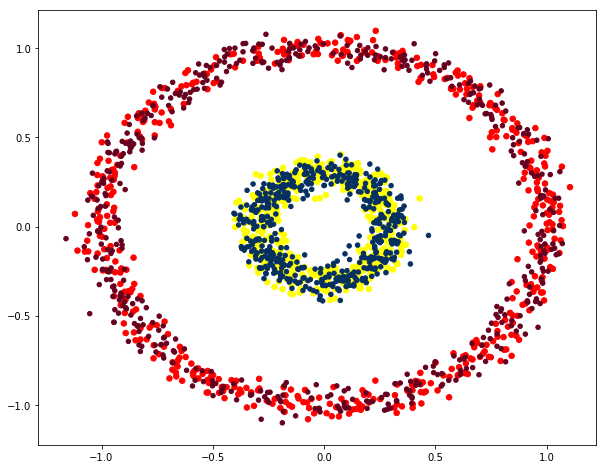

In [6]:
f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(10,8))
axis.scatter(X_train[:,0],X_train[:,1],s=30,c=y_train,zorder=10,cmap='autumn')
axis.scatter(X_test[:,0],X_test[:,1],s=20,c=y_test,zorder=10,cmap='RdBu')
plt.axis('tight')
plt.legend(fancybox=True, loc=(1,0.8))
plt.show()

#### b) Demuestre  experimentalmente que  una  red  neuronal  artificial  correspondiente  a  1  sola  neurona  (i.e.sin capas escondidas) no puede resolver satisfactoriamente el problema. Puede utilizar la función de activaci ́on y el método deentrenamiento que prefiera. Sea convincente: por ejemplo, intente modificar los parámetros de la máquina de aprendizaje,reportando métricas que permitan evaluar el desempeño del modelo en el problema con cada cambio efectuado.Adapte tambi ́en la funci ́on plot classifier para que  represente  gr ́aficamente  la  soluci ́on  encontrada  por  la  red  neuronal. Describa  y  explique  lo  que observa, reportando gr ́aficos de la soluci ́on s ́olo para algunos casos representativos.

In [7]:
#Numero de neuronas
n_h=1
kernel =['uniform','glorot_normal','random_normal']
activation = ['sigmoid','relu','softmax']
loss = ['binary_crossentropy','poisson','squared_hinge']
score_dict={}
i=0
for times in range(5):
    for k,a,l in itertools.product(kernel,activation,loss):
        model = Sequential()
        model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer=k, activation=a))
        model.compile(optimizer=SGD(lr=1), loss=l, metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
        scores = model.evaluate(X_test, y_test)
        
        name = 'init: {},activation: {},loss: {}'.format(k,a,l)

        #El registro aparece por primera vez, se agrega la key al diccionario

        if (name in score_dict):
            score_dict[name].append(scores[1])
            i=i+1
        #Si existe se agrega el valor a la lista
        else:
            score_dict[name] = [scores[1]]
            i=i+1
    i=0
print('Finalizado.')

1000/1000 [==============================] - 1s 984us/step
Finalizado.


In [7]:
df = pd.DataFrame(score_dict)
df

,"init: glorot_normal,activation: relu,loss: binary_crossentropy","init: glorot_normal,activation: relu,loss: poisson","init: glorot_normal,activation: relu,loss: squared_hinge","init: glorot_normal,activation: sigmoid,loss: binary_crossentropy","init: glorot_normal,activation: sigmoid,loss: poisson","init: glorot_normal,activation: sigmoid,loss: squared_hinge","init: glorot_normal,activation: softmax,loss: binary_crossentropy","init: glorot_normal,activation: softmax,loss: poisson","init: glorot_normal,activation: softmax,loss: squared_hinge","init: random_normal,activation: relu,loss: binary_crossentropy",...,"init: random_normal,activation: softmax,loss: squared_hinge","init: uniform,activation: relu,loss: binary_crossentropy","init: uniform,activation: relu,loss: poisson","init: uniform,activation: relu,loss: squared_hinge","init: uniform,activation: sigmoid,loss: binary_crossentropy","init: uniform,activation: sigmoid,loss: poisson","init: uniform,activation: sigmoid,loss: squared_hinge","init: uniform,activation: softmax,loss: binary_crossentropy","init: uniform,activation: softmax,loss: poisson","init: uniform,activation: softmax,loss: squared_hinge"
0,0.000,0.493,0.371,0.643,0.569,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.466,0.493,0.422,0.587,0.493,0.493,0.493,0.493
1,0.000,0.447,0.411,0.343,0.625,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.505,0.493,0.497,0.589,0.493,0.493,0.493,0.493
2,0.455,0.431,0.355,0.301,0.569,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.265,0.493,0.652,0.588,0.493,0.493,0.493,0.493
3,0.000,0.410,0.353,0.670,0.637,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.428,0.493,0.384,0.588,0.493,0.493,0.493,0.493
4,0.000,0.551,0.493,0.658,0.632,0.493,0.493,0.493,0.493,0.0,...,0.493,0.0,0.479,0.493,0.559,0.590,0.493,0.493,0.493,0.493


Con los datos de la celda, se observa que con un modelo de una sola neurona se obtienen resultados que los muchos estan bajo el 50% de accuracy, pero además se nota que estos fluctuan si se repite el experimento. Por lo cual se toma para ver las fronteras a ciertos representates que sus valores se mantienen consistentes o sobre el 50%.
$$init: glorot_normal,activation: sigmoid,loss: poisson$$
$$init: glorot_normal,activation: sigmoid,loss: squared_hinge$$
$$init: uniform,activation: sigmoid,loss: binary_crossentropy$$
$$init: uniform,activation: sigmoid,loss: poisson$$

Caso 1


C:\Python36\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


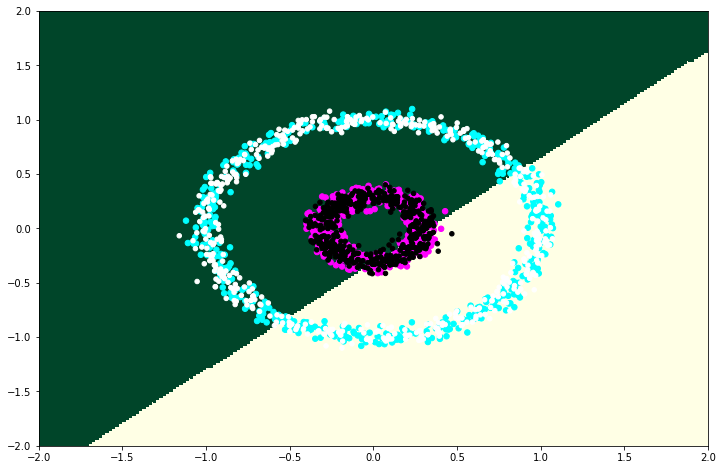

Caso 2


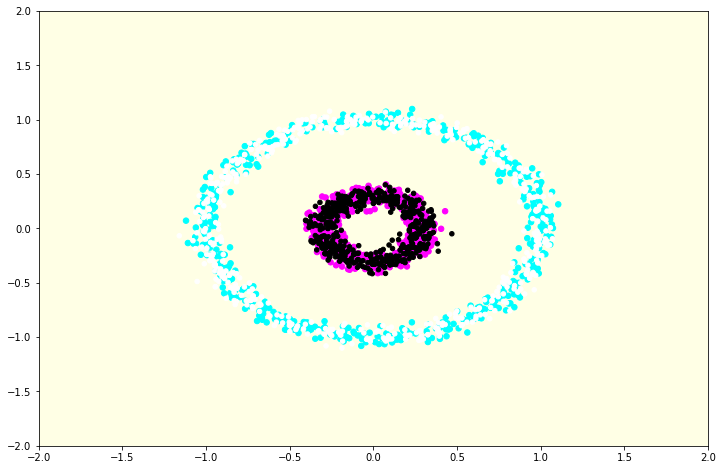

Caso 3


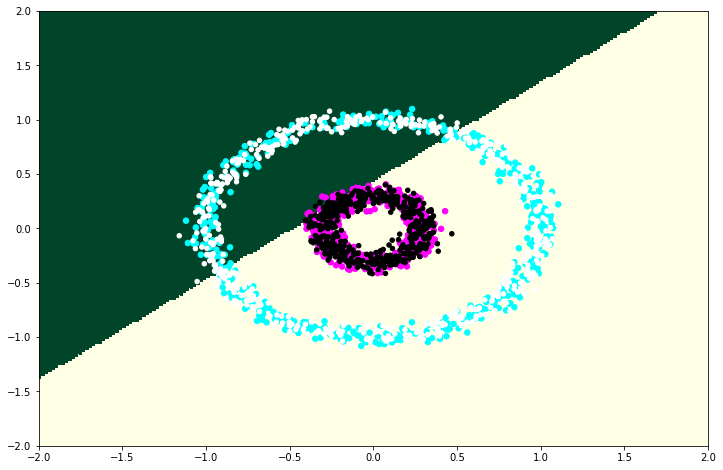

Caso 4


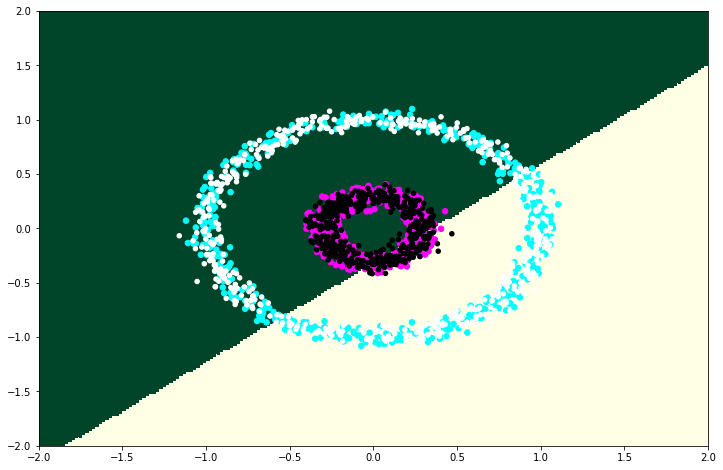

In [17]:
model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='glorot_normal', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='poisson', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
print('Caso 1')
plot_classifier(model,X_train,y_train,X_test,y_test,'ann')

model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='glorot_normal', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
print('Caso 2')
plot_classifier(model,X_train,y_train,X_test,y_test,'ann')

model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
print('Caso 3')

plot_classifier(model,X_train,y_train,X_test,y_test,'ann')

model = Sequential()
model.add(Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='poisson', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
print('Caso 4')
plot_classifier(model,X_train,y_train,X_test,y_test,'ann')

Si bien los números obtenidos para la accuracy parece prometedores, se ve en las fronteras que esto es completamente lo contrario, y es un caso donde esta metrica capturo la mitad de 1 clase y la otra mitad como otra en los ultimos ejemplos y el el segundo simplemente toda la clase es una, la definición de accuracy
$$accuracy\, =\, \frac{t_p+t_n}{t_p+t_n+f_n+f_p} $$
podemos asegurar entonces la mayoria son $true\,negatives$ osea que si bien, tiene algo de presición esto no es el coomportamiento que se espera. Por lo que se puede descartar como clasificador

#### c)  Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema obtenido en (a). Puede utilizar la arquitectura y el método de entrenamiento que prefiera, pero en esta actividad puede optar tranquilamente por usar los hiper-parámetros que se entregan como referencia en el código de ejemplo. Cambie el número de neuronas N h en la red entre 2 y 32 en potencias de 2, graficando el error de entrenamiento y pruebas como  función de N h . Describa y explique lo que observa. Utilice la función plot classifier , diseñada anteriormente, para construir gráficos de la solución en algunos casos representativos

[1, 2, 4, 8, 16, 32]
1000/1000 [==============================] - 0s 140us/step

 Test Accuracy = 1.0, n=4


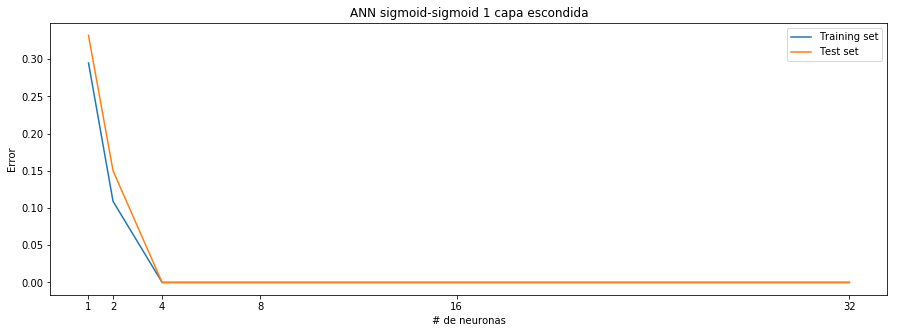

In [9]:
N_h = [pow(2,k) for k in range(6)]
print(N_h)
best_acc = [0,0]
info_train = []
info_test = []
for n in N_h:
    model = Sequential()
    model.add(Dense(n, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
            
    info_train.append(model.evaluate(X_train, y_train)[1])
    
    test_acc = model.evaluate(X_test, y_test)[1]
    info_test.append(test_acc)
    if test_acc > best_acc[0]:
        best_acc = [test_acc,n]
        
print ("\n Test Accuracy = {}, n={}".format(best_acc[0],best_acc[1]))

error_train = [1-i for i in info_train]
error_test = [1-j for j in info_test]


plt.figure( figsize=(15,5))
plt.plot(N_h,error_train, label = "Training set")
plt.plot(N_h,error_test, label = "Test set")
plt.xticks(N_h)
plt.xlabel('# de neuronas')
plt.ylabel('Error')
plt.title('ANN sigmoid-sigmoid 1 capa escondida')
plt.legend(loc = 'upper right')
plt.show()

C:\Python36\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


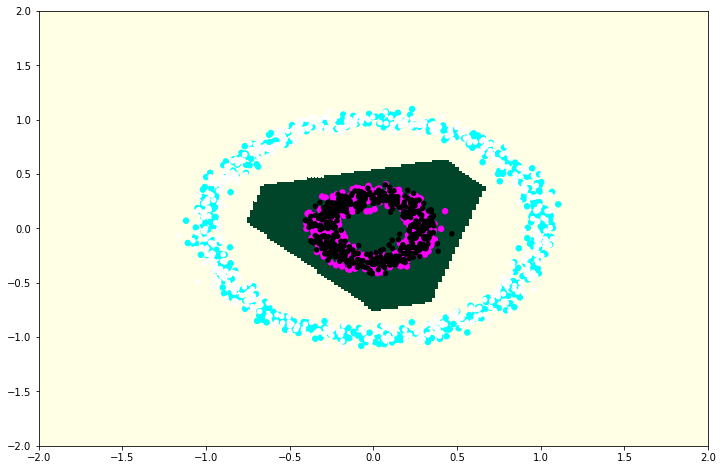

In [50]:
model = Sequential()
model.add(Dense(4, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
plot_classifier(model,X_train,y_train,X_test,y_test,'ann')

Se puede nota el contraste con el modelo de 1 neurona, el que posee una capa escondida genera ya desde 4 neuronas una clasificación perfecta entre las dos clases, por lo que es razonable decir que esta arquitectura si resuelve el problema planteado

#### d) Demuestre experimentalmente que stump (árbol de clasificación de 1 nivel) no puede resolver satisfactoriamente el problema anterior. Puede utilizar el criterio y la función de partición que prefiera. Sea convincente:  por  ejemplo,  intente  modificar  los  parámetros  de  la  máquina,  reportando  métricas  que permitan evaluar el desempeño del modelo en el problema con cada cambio efectuado. Adapte también la función plot classifier para que represente gráficamente la solución encontrada por el árbol. Describa y explique lo que observa, reportando gráficos de la solución sólo para algunos casos representativos.

sklearn decision tree, training error: 0.295000
sklearn decision tree, testing error: 0.330000
tree 1 Training Accuracy: 0.705000
tree 1 Test Accuracy: 0.670000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

Categoria 1       0.98      0.36      0.52       507
Categoria 2       0.60      0.99      0.75       493

avg / total       0.79      0.67      0.63      1000



C:\Python36\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


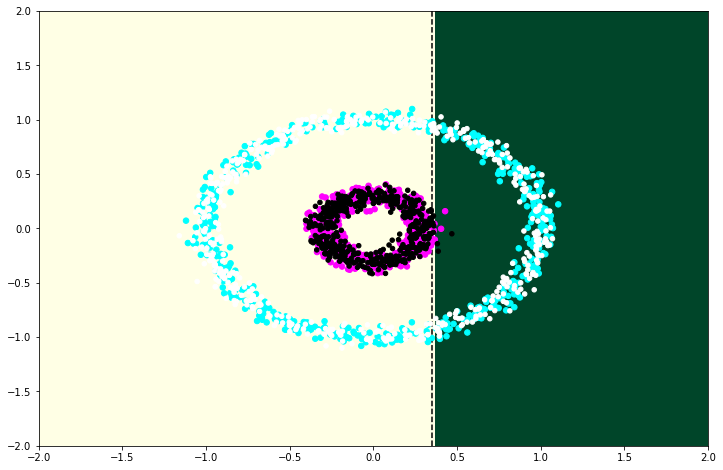

sklearn decision tree, training error: 0.328000
sklearn decision tree, testing error: 0.321000
tree 1 Training Accuracy: 0.672000
tree 1 Test Accuracy: 0.679000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

Categoria 1       1.00      0.37      0.54       507
Categoria 2       0.61      1.00      0.75       493

avg / total       0.81      0.68      0.64      1000



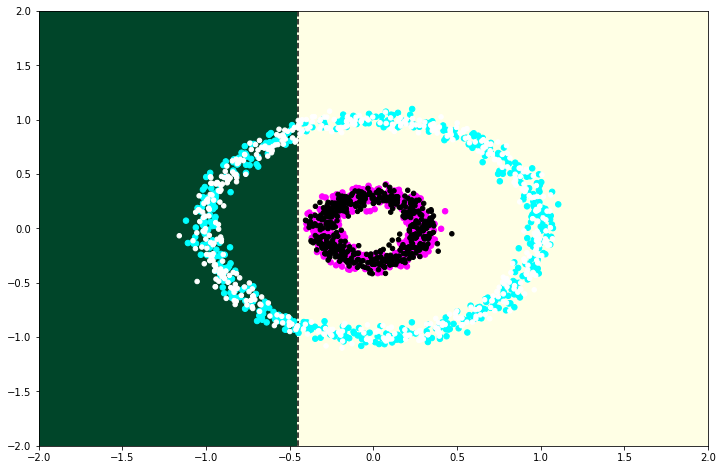

sklearn decision tree, training error: 0.303000
sklearn decision tree, testing error: 0.342000
tree 1 Training Accuracy: 0.697000
tree 1 Test Accuracy: 0.658000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

Categoria 1       0.99      0.33      0.49       507
Categoria 2       0.59      1.00      0.74       493

avg / total       0.80      0.66      0.62      1000



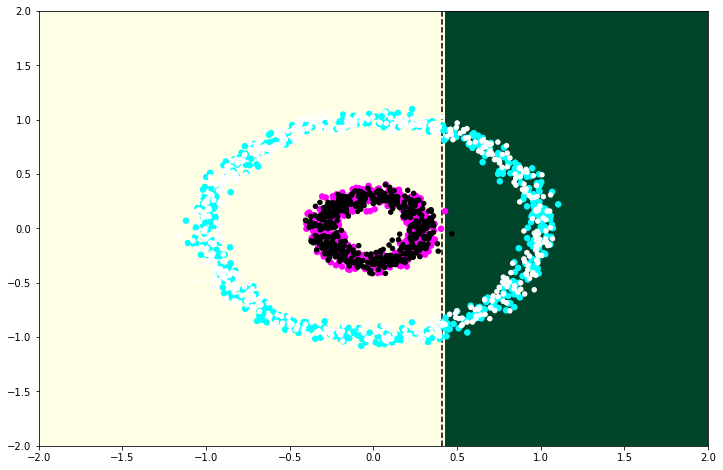

sklearn decision tree, training error: 0.328000
sklearn decision tree, testing error: 0.321000
tree 1 Training Accuracy: 0.672000
tree 1 Test Accuracy: 0.679000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

Categoria 1       1.00      0.37      0.54       507
Categoria 2       0.61      1.00      0.75       493

avg / total       0.81      0.68      0.64      1000



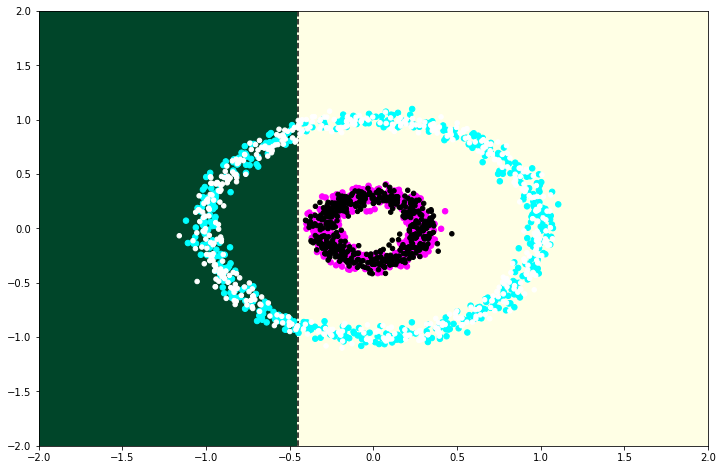

Finalizado.


In [72]:
criterion =['gini','entropy']
splitter = ['best','random']

for c,s in itertools.product(criterion,splitter):
    name = '{}-{}'.format(c,s)
    model = Tree(criterion=c,splitter=s,random_state=0,max_depth=1)
    model.fit(X_train,y_train)
    
    score_the_model(model,X_train,y_train,X_test,y_test,'tree 1',['Categoria 1','Categoria 2'])
    plot_classifier(model,X_train,y_train,X_test,y_test,"tree")
print('Finalizado.')

Tenemos que el stump logra buenos resultados que pueden ser utilez según la indicadores como presicion y recall que miden los *% de seleccionar itemes correctamente* y el *% itemes correctos seleccionados*, pero si hacemos el tradeoff entre estos como iguales en importancia oara nuestra clasificacion,usando el f1 score nos damos cuenta que la clasificacion es pobre dado que no logra separar nuestras dos clases como se quiere lograr (lo cual se ve graficamente en los plot de arriba), en vez de ello el stump se inclina a una clase segun sus criterios y deja lo demas fuera.

#### e) Demuestre experimentalmente que un árbol de clasificación de múltiples niveles puede resolver satis- factoriamente el problema estudiado. Puede utilizar el criterio y la función de partición que prefiera,pero puede optar tranquilamente por usar los hiper-parámetros que se entregan como referencia en el código de ejemplo. Cambie el número de niveles admitidos en el árbol N t entre 2 y 20, graficando el error de entrenamiento y pruebas como función de N t. Describa y explique lo que observa. Utilice la función plot classifier, diseñada anteriormente, para construir gráficos de la solución en algunos casos representativos.


In [75]:
criterion =['gini','entropy']
splitter = ['best','random']
N_t = range(1,50)
model = Tree(random_state=0)
    
param_grid = dict(criterion = criterion,splitter = splitter, max_depth=N_t)
grid = GridSearchCV(estimator = model,param_grid=param_grid,n_jobs=-1)
grid_result = grid.fit(X_train,y_train)

print('Mejor: %f usando %s '%(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Mejor: 0.999000 usando {'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'} 


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


C:\Python36\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


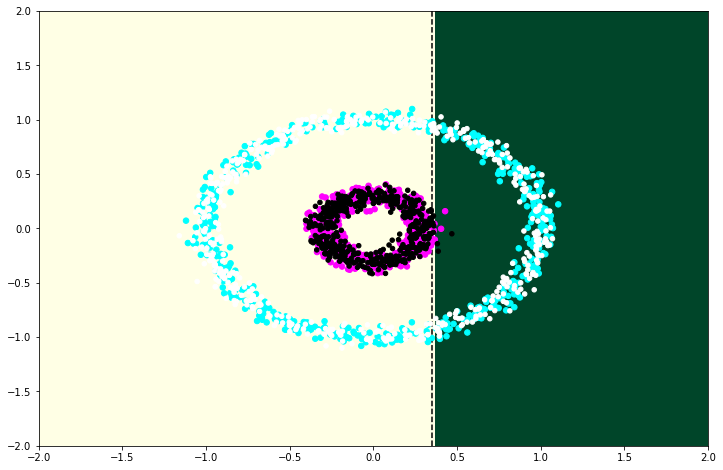

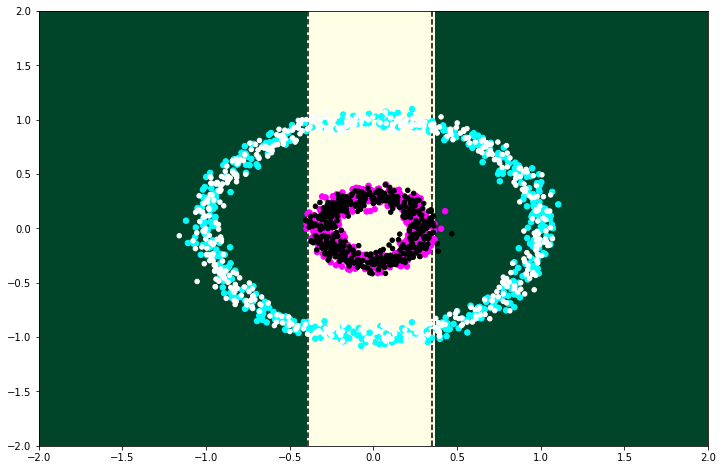

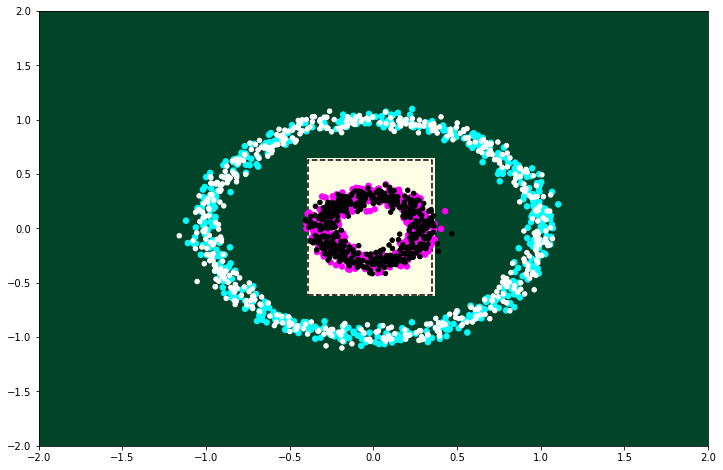

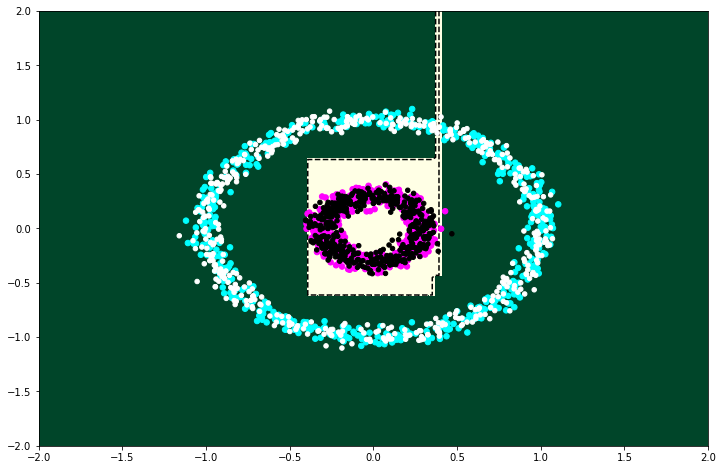

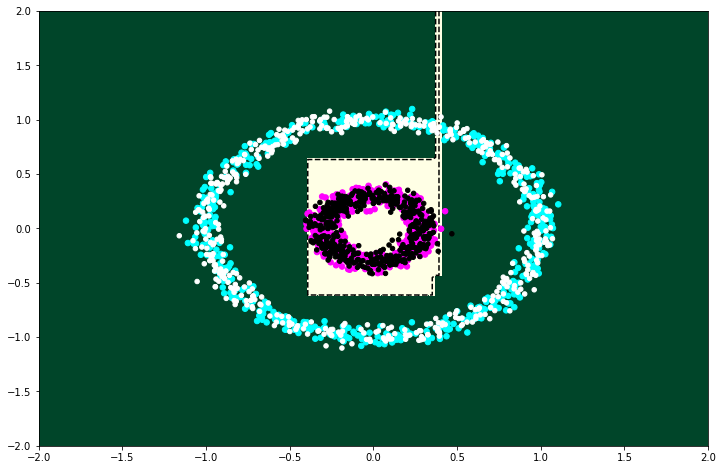

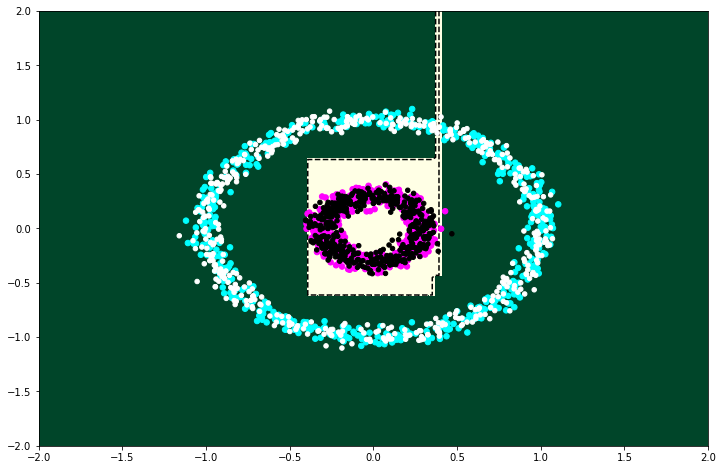

best test accuracy :0.994 , n:4
Finalizado.


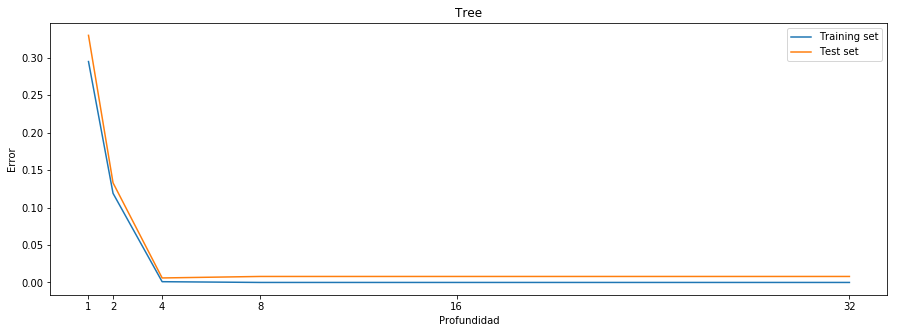

In [80]:
N_t = [i for i in range(2,21)]
print(N_t)
info_train = []
info_test = []
best_acc = [0,0]
info_train = []
info_test = []
for n in N_h:
    model = Tree(criterion='gini',splitter='best',random_state=0,max_depth=n)
    model.fit(X_train,y_train)
    info_train.append(model.score(X_train, y_train))
    
    test_acc = model.score(X_test, y_test)
    
    info_test.append(test_acc)
    if test_acc > best_acc[0]:
        best_acc = [test_acc,n]
    plot_classifier(model,X_train,y_train,X_test,y_test,"tree")
print ('best test accuracy :{} , n:{}'.format(best_acc[0],best_acc[1]))    
print('Finalizado.')
        
error_train = [1-i for i in info_train]
error_test = [1-j for j in info_test]


plt.figure( figsize=(15,5))
plt.plot(N_h,error_train, label = "Training set")
plt.plot(N_h,error_test, label = "Test set")
plt.xticks(N_h)
plt.xlabel('Profundidad')
plt.ylabel('Error')
plt.title('Tree')
plt.legend(loc = 'upper right')
plt.show()

En contraste al caso del stump, al tener mayor libertad en la profundidad, este árbol es capaz de lograr clasificar muy bien las dos clases (solo unos pocos puntos quedando fuera) con solo 4 niveles, esto se puede observar en los plot cuando por cada nivel que logra encerrar mejor el circulo interior. Por lo que este si logra resolver el problema de clasificación como se esperaba.

#### f) Como ya se demostró experimentalmente que este problema es linealmente inseperable, ahora se pide experimentar otra alternativa. Para ello deberá realizar una proyección de los datos a un nuevo espacio dimensional (manifold) en el cual se reconozcan sus patrones no lineales, para poder trabajarlos confronteras lineales. Utilice la técnica de PCA con la ayuda de un Kernel  Gaussiano para extraer sus vectores con dimensión infinita de mayor varianza.

In [27]:
kpca = KernelPCA(n_components=2,kernel="rbf", gamma=5,fit_inverse_transform=True)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

Xback_train = kpca.inverse_transform(Xkpca_train)
Xback_test = kpca.inverse_transform(Xkpca_test)

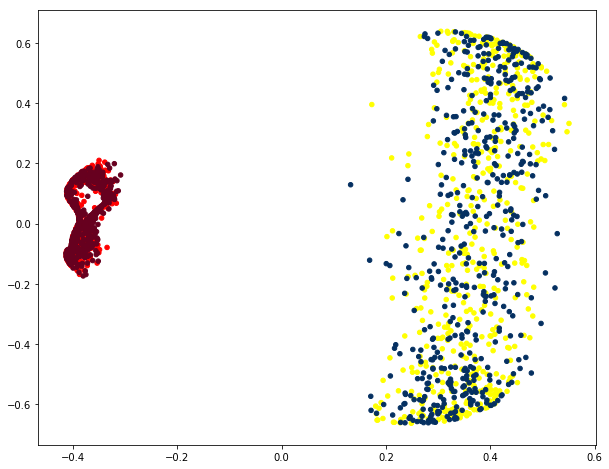

In [28]:
f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(10,8))
axis.scatter(Xkpca_train[:,0],Xkpca_train[:,1],s=20,c=y_train,zorder=20,cmap='autumn')
axis.scatter(Xkpca_test[:,0],Xkpca_test[:,1],s=20,c=y_test,zorder=20,cmap='RdBu')
plt.axis('tight')
plt.legend(fancybox=True, loc=(1,0.8))
plt.show()

Con la separación de las dos clases que produjo PCA con kernel gaussiano se espera que un método linal pueda obtener una buena clasificación.

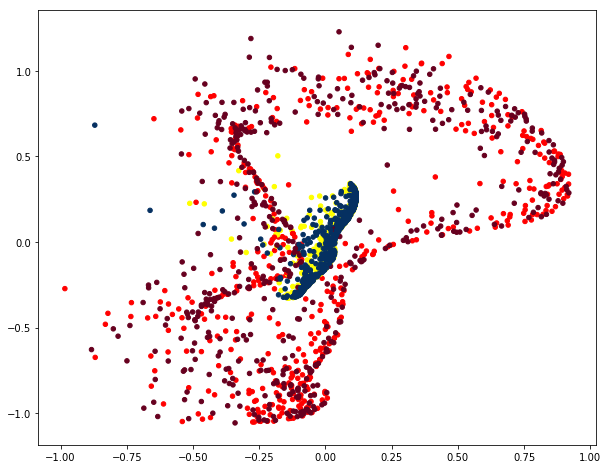

In [29]:
f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(10,8))
axis.scatter(Xback_train[:,0],Xback_train[:,1],s=20,c=y_train,zorder=20,cmap='autumn')
axis.scatter(Xback_test[:,0],Xback_test[:,1],s=20,c=y_test,zorder=20,cmap='RdBu')
plt.axis('tight')
plt.legend(fancybox=True, loc=(1,0.8))
plt.show()

*Al ver como quedan los datos pasados por una transformación inversa se aprecia que el espacio queda totalmente deformado, haciendo que el trabajo con este sea más dificil, por lo que esta experimento queda hasta aquí*

#### g) Ajuste un algoritmo de aprendizaje con fronteras lineal para los datos proyectados en este nuevo espacio que captura sus  componentes no lineales, muestre gráficamente que el problema ahora puede ser resulto con estos métodos. Reporte métricas para evaluar el desempeño, comente y concluya.

C:\Python36\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


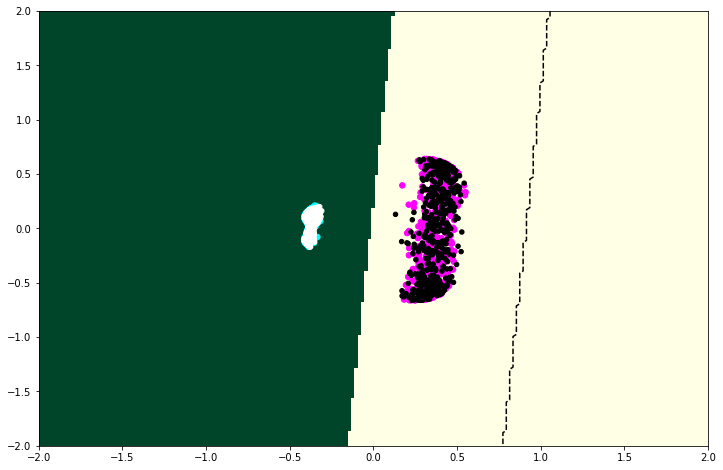

sklearn decision tree, training error: 0.000000
sklearn decision tree, testing error: 0.000000
SVM Training Accuracy: 1.000000
SVM Test Accuracy: 1.000000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

Categoria 1       1.00      1.00      1.00       507
Categoria 2       1.00      1.00      1.00       493

avg / total       1.00      1.00      1.00      1000



In [48]:
model1 = SVC(random_state=44,probability=True,kernel='linear')
model1.fit(Xkpca_train, y_train)   

plot_classifier(model1,Xkpca_train,y_train,Xkpca_test,y_test,"tree")
score_the_model(model1,Xkpca_train,y_train,Xkpca_test,y_test,'SVM',['Categoria 1','Categoria 2'])


Se puede observa lo esperado en la parte f) que el plano separador de las clases esta bien definido ya que el kernel gaussiano logra separar el problema y dejarlo como uno que esta bien definido para separarlo con un método lineal como es una SVM con kernel lineal